In [10]:
import warnings
import numpy as np
import pandas as pd
import sktime
from sktime.utils.plotting import plot_series
from sktime.split import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.datatypes import convert_to
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

warnings.filterwarnings("ignore")


# features_list = ["price","demand","temp_air","timestamp"]
features_list = ["sa1.price", "sa1.demand", "sa1.temperature", "Timestamp"]

fh_range = np.arange(1,37) # look ahead forecast horizon 12hrs:144, 6hrs:72, 3hrs:36
fh = ForecastingHorizon(fh_range, is_relative=True) # maybe False
daily_sp = 288 # 1 day, 5 min intervals

# use last week data
# min_inputs = 288 # 1 day, 5 min intervals
# train_raw = train_raw[-min_inputs:]

# if test on different months, use below
# train 2023 - april, may, october,


train_raw = pd.read_csv('../data/30days_data_17_Apr_2024.csv')
train = train_raw[features_list]
# rename columns
train.columns = ["price", "demand", "temperature", "timestamp"]
# remove last 6 rows
train = train[:-6]

# cv 70:30 of last 30 days (100%)
# 1 hour predictions, pick 24 hour to predict 1 hour future, pick different nodes to predict


# import dataframe X_train into sktime
y_train_series = train['price']
# convert to Series type
y_train_series = convert_to(y_train_series, to_type='pd.Series')


In [11]:
X_train_series = train.drop(columns=['price'])
# change column to timestamp
X_train_series['timestamp'] = pd.to_datetime(X_train_series['timestamp'])

# impute temperature with ffill
X_train_series['temperature'] = X_train_series['temperature'].ffill()

y_train, y_test, X_train, X_test = temporal_train_test_split(y=y_train_series, X=X_train_series, fh=fh)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(type(X_train), type(y_train), type(X_test), type(y_test))

X_train_tab = X_train.copy()
X_train_tab = X_train.drop(columns=['timestamp'])
X_test_tab = X_test.copy()
X_test_tab = X_test.drop(columns=['timestamp'])

(8605, 3) (8605,) (36, 3) (36,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [12]:
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.compose import ForecastingPipeline
from sklearn.preprocessing import MinMaxScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
forecaster = make_reduction(xgb, window_length=288, strategy="recursive")

forecaster.fit(y=y_train_series, fh=fh)
y_pred_xgb = forecaster.predict(fh)

In [13]:
pipe = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="ffill")),
        ("scaler", TabularToSeriesAdaptor(MinMaxScaler())),
        ("forecaster", forecaster),
    ]
)
y_pred_pipe = pipe.fit_predict(y=y_train_series, fh=fh)
y_pred_reshaped = y_pred_pipe.values.reshape(len(y_pred_pipe), 1)

In [16]:
print(y_pred_reshaped.shape)

(36, 1)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

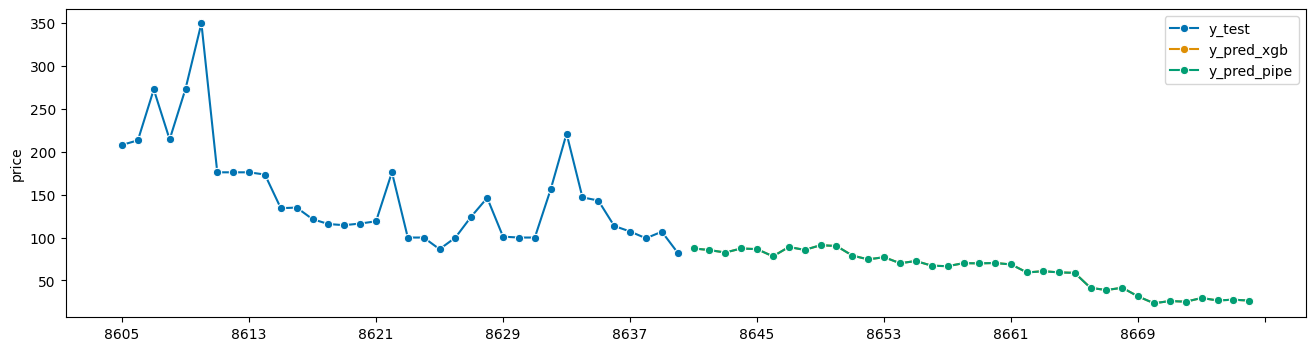

In [14]:
plot_series(y_test, y_pred_xgb, y_pred_pipe, labels=[ "y_test", "y_pred_xgb", "y_pred_pipe"])

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0)
forecaster = make_reduction(cat, window_length=288, strategy="recursive")
forecaster.fit(y=y_train, fh=fh)
y_pred_cb = forecaster.predict()

In [ ]:
from sktime.split import SingleWindowSplitter
validation_size = 36
cv = SingleWindowSplitter(window_length=len(y_train)-validation_size, fh=validation_size)


In [ ]:

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=72, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)
gscv.fit(y=y_train)
y_pred_reg = gscv.predict(fh)

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.compose import Permute
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer
from sklearn.preprocessing import MinMaxScaler
from sktime.forecasting.ltsf import LTSFNLinearForecaster 
from sktime.forecasting.ltsf import LTSFDLinearForecaster
from sktime.forecasting.compose import MultiplexForecaster
from sktime.transformations.series.lag import Lag
from sktime.forecasting.trend import PolynomialTrendForecaster
from lightgbm import LGBMRegressor

forecaster = MultiplexForecaster(
    forecasters=[
        ("nlinear", LTSFNLinearForecaster(seq_len=288, pred_len=36, num_epochs=100, optimizer='Adam', criterion='MSE')),
        ("dlinear", LTSFDLinearForecaster(seq_len=288, pred_len=36, num_epochs=100, optimizer='Adam', criterion='MSE')),
    ]
)

pipe_y = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer(method="ffill")),
        ("detrender", OptionalPassthrough(Detrender(forecaster=PolynomialTrendForecaster(LGBMRegressor(objective='tweedie'))))),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer(sp=daily_sp, model="additive"))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(MinMaxScaler()))),
        ("forecaster", forecaster)
    ]
)
permuted_y = Permute(pipe_y, permutation=None)

pipe_X = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer(method="ffill")),
        ("detrender", OptionalPassthrough(Detrender(forecaster=PolynomialTrendForecaster(LGBMRegressor(objective='tweedie'))))),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer(sp=daily_sp, model="additive"))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(MinMaxScaler()))),
        ("forecaster", permuted_y),
    ]
)
permuted_X = Permute(pipe_X, permutation=None)

In [ ]:
gscv = ForecastingGridSearchCV(
    forecaster=permuted_X,
    param_grid={
        "estimator__forecaster__permutation": [
            ["imputer", "detrender", "deseasonalizer", "scaler", "forecaster"],
            ["imputer", "deseasonalizer", "detrender", "scaler", "forecaster"],
        ],
        "permutation": [
            ["imputer", "detrender", "deseasonalizer", "scaler", "forecaster"],
            ["imputer", "scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "estimator__forecaster__estimator__scaler__passthrough": [True, False],
        "estimator__scaler__passthrough": [True, False],
        "selected_forecaster": ["nlinear", "dlinear"],
    },
    cv=cv,
    error_score='raise',
    scoring=MeanSquaredError(square_root=True),
)

gscv.fit(y=y_train, X=X_train_tab, fh=fh)
y_pred_gscv = gscv.predict(X=X_test_tab)

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.compose import Permute
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer
from sklearn.preprocessing import MinMaxScaler
from sktime.transformations.series.lag import Lag

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=288, strategy="recursive")

pipe_y = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer(method="ffill")),
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(MinMaxScaler()))),
        ("lag_transformer", Lag([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 48, 72, 96, 120, 144], index_out="original")),
        ("forecaster", forecaster)
    ]
)
permuted_y = Permute(pipe_y, permutation=None)

pipe_X = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer(method="ffill")),
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(MinMaxScaler()))),
        ("lag_transformer", Lag([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 48, 72, 96, 120, 144], index_out="original")),
        ("forecaster", permuted_y),
    ]
)
permuted_X = Permute(pipe_X, permutation=None)

In [ ]:
gscv_lag = ForecastingGridSearchCV(
    forecaster=permuted_X,
    param_grid={
        'estimator__max_depth': [3, 5, 6, 10, 15, 20],
        'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'estimator__subsample': np.arange(0.5, 1.0, 0.1),
        'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
        'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
        'estimator__n_estimators': [100, 500, 1000],
        "estimator__forecaster__permutation": [
            ["lag_transformer", "imputer", "detrender", "deseasonalizer", "scaler", "forecaster"],
            ["lag_transformer", "imputer", "scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "permutation": [
            ["lag_transformer", "imputer", "detrender", "deseasonalizer", "scaler", "forecaster"],
            ["lag_transformer", "imputer", "scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "estimator__forecaster__estimator__scaler__passthrough": [True, False],
        "estimator__scaler__passthrough": [True, False],
    },
    cv=cv,
    error_score='raise',
    scoring=MeanSquaredError(square_root=True),
)

gscv_lag.fit(y=y_train)
y_pred_lag = gscv_lag.predict(fh)

In [ ]:
# plot predictions
plot_series(y_test, y_pred_xgb, y_pred_lag, y_pred_reg, labels=["y_test", "y_pred_xgb", "y_pred_lag", "y_pred_reg"])

In [ ]:
gscv.best_params_